# 「プチ」勉強会 20230812
* 今回は、実践課題「中古車価格を予測しよう」の探索。
* 最初に断っておくと、実はLightGBMでやるといきなりRMSE3000前後が出る。実質それで打ち止めになるのでスコアだけならそれでおしまい。学びのない課題となる。
* だから、解説動画は敢えて重回帰でやられている。<br>
「なんでわざわざ？」との質問には、現場ではエクセルで実装でき予測内容を説明できる重回帰から入るのが常道とのことだった。この仕事は説明力が鍵だと。
* 私はデータアナリストになりたいわけではないが、EDAや特徴量エンジニアリングの理解を深めるために、私もここは重回帰縛りとする。
* そして、今回の課題は一言で言えば「ノイズ」だろう。<br>
中古車価格という命題に対して関連ありそうな情報をなんでもつぎ込むのではなく、影響度合いを確認しながら「利きを調整する」ことでスコア改善を図る。<br>
LightGBMはその辺りがかなり自動化されている。なんでもLightGBMでやれば良いわけではないが、この問題では特に有効のようだ。
* なお、重回帰は外れ値に弱いからといって、なんでも対数変換したりデータ間の平仄を揃えるために正則化すれば良いとは限らない。<br>
結果が伴わない場合は別法を考慮すべき。ここではターゲットエンコーディングの方が有効だった。
* また、今回は「引き算の特徴量エンジニアリング」のほかに「予測の分割実施」を試し、これが成功した。この実装にはPandasのノウハウも重要。

## 今回取り組んでみたこと
1. まず、これはノイズの問題だと分かった。「引き算の特徴量エンジニアリング」が強く意識された。
```
   ・データに電気自動車のBMW i3が入っている。燃費470、排気量0なんてのが平気で紛れ込んでいる。
   　しかもfuelTypeがElectricじゃなくHiblidなどいろいろになっている。削除しようにもtestデータにも入っているから使うしかない。
   ・taxが意味不明。engineSizeと相関はあるが、これはPriceの控除要因なのか。
   ・6000のデータに対してbrandのほかにmodelが90もある。そもそも特徴量がcarIDを除いてデフォルトで9つもある。
   ・そして、mileageは逆相関データだ。重回帰殺しの要素に満ちていて、数学的変換を行ってもスコアはあまり改善しない。
```
2. そして、改めて考えたことは、これが中古車価格だということ。
```
   ・そもそも中古車の価格は、車種をベースに排気量や装備を含めたグレードと配色などがあり、そこに年式と走行距離による減価と車検が考慮されるのだろう。
   　brandはそもそも車種に包含され、燃費なども車種の属性のひとつ。こうしたドメイン知識を探索して活用するのも大切なEDAだ。
   　確かに車種単独でみてもpriceとの相関は高く、通常のやり方でも相応の結果にはなるが、そもそも車種毎に予測すれば特徴量の解釈もより分かりやすい。
   ・但し、modelが90もあるので車種に依ってはサンプル数が少ない問題はある。
　   訓練データに1台あれば予測はできるが、このトレードオフの結果がどうでるかは実際やってみないと分からなかった。（過学習のリスク）
   ・なお、maskを使った配列計算を活用すれば、車種毎に予測するという一見複雑な今回の試みもすっきりしたコードで書ける。この手法は応用範囲が広い。
```

## 中古車価格を予測しよう

In [219]:
# 0-1
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ここから機械学習用ライブラリ
from sklearn.linear_model import LinearRegression       # 重回帰
from sklearn.tree import DecisionTreeRegressor          # 決定木(比較対象)
import lightgbm                                         # LightGBM（おまけ）

# ユーティリティ
from sklearn.metrics import mean_squared_error          # RMES
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

# 表示桁数の設定
%precision 3
pd.options.display.precision = 3

sns.set(style='white')
import japanize_matplotlib

In [220]:
# 0-2
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\used_car\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\used_car\\test.csv')


## データ概観

In [221]:
# 1-0
# 訓練データ
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())
display(df_test.describe())
display(df_test.describe(include='object'))


# 欠損値なし
# priceの平均23000台、標準偏差16400なので、普通ならRMSE1万切ればまずまずと思うところ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6105 entries, 0 to 6104
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         6105 non-null   int64  
 1   brand         6105 non-null   object 
 2   model         6105 non-null   object 
 3   year          6105 non-null   int64  
 4   transmission  6105 non-null   object 
 5   mileage       6105 non-null   int64  
 6   fuelType      6105 non-null   object 
 7   tax           6105 non-null   float64
 8   mpg           6105 non-null   float64
 9   engineSize    6105 non-null   float64
 10  price         6105 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 524.8+ KB


None

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,16542,vauxhall,GTC,2015,Manual,29188,Petrol,160.0,47.1,1.4,8927
1,12581,merc,CLS Class,2016,Automatic,44753,Diesel,125.0,57.7,2.1,17500
2,13317,merc,V Class,2019,Manual,100,Diesel,145.0,46.3,2.1,25000
3,12797,toyota,Supra,2019,Automatic,10,Petrol,145.0,34.5,3.0,49499
4,13941,hyundi,Santa Fe,2017,Semi-Auto,28847,Diesel,240.0,42.8,2.2,21499


,carID,year,mileage,tax,mpg,engineSize,price
count,6105.000,6105.000,6105.000,6105.000,6105.000,6105.000,6105.000
mean,15819.260,2016.767,24526.806,151.929,50.177,2.128,23716.391
std,2201.001,2.879,23775.011,80.786,35.540,0.779,16398.802
min,12000.000,1970.000,1.000,0.000,2.800,0.000,450.000
25%,13935.000,2016.000,5505.000,145.000,38.200,1.600,12450.000
50%,15814.000,2017.000,18299.000,145.000,47.100,2.000,19334.000
75%,17718.000,2019.000,36284.000,150.000,54.300,2.800,30990.000
max,19631.000,2020.000,212000.000,580.000,470.800,6.600,139995.000


,brand,model,transmission,fuelType
count,6105,6105,6105,6105
unique,9,90,4,5
top,merc,CLS Class,Manual,Diesel
freq,990,200,2325,3724


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527 entries, 0 to 1526
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         1527 non-null   int64  
 1   brand         1527 non-null   object 
 2   model         1527 non-null   object 
 3   year          1527 non-null   int64  
 4   transmission  1527 non-null   object 
 5   mileage       1527 non-null   int64  
 6   fuelType      1527 non-null   object 
 7   tax           1527 non-null   float64
 8   mpg           1527 non-null   float64
 9   engineSize    1527 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 119.4+ KB


None

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,14530,merc,GLS Class,2019,Semi-Auto,29,Diesel,145.0,34.0,3.0
1,12614,ford,Grand C-MAX,2016,Manual,16271,Diesel,30.0,64.2,1.5
2,15195,skoda,Yeti,2015,Manual,22758,Petrol,125.0,51.4,1.2
3,18116,skoda,Scala,2020,Semi-Auto,1000,Petrol,145.0,47.1,1.0
4,13959,vw,Amarok,2015,Automatic,32800,Diesel,260.0,35.3,2.0


,carID,year,mileage,tax,mpg,engineSize
count,1527.000,1527.000,1527.000,1527.000,1527.000,1527.000
mean,15800.469,2016.591,26080.597,155.573,50.123,2.127
std,2213.192,2.925,24823.195,85.804,35.746,0.794
min,12013.000,1999.000,1.000,0.000,11.000,0.000
25%,13807.000,2015.000,6846.500,145.000,38.700,1.600
50%,15850.000,2017.000,20828.000,145.000,47.100,2.000
75%,17737.000,2019.000,37438.500,160.000,54.300,2.800
max,19622.000,2020.000,259000.000,580.000,470.800,6.200


,brand,model,transmission,fuelType
count,1527,1527,1527,1527
unique,9,89,3,5
top,ford,Santa Fe,Manual,Diesel
freq,247,54,612,927


## EDA（データ探索）

```Dataset.columns
price         : 中古車価格(int)
carID         : ユニークな中古車の番号(object)
brand         : 企業及びブランド(object)
model         : 車のモデル(object)
year          : 年式(int)
transmission  : トランスミッション(object)
mileage       : 走行距離(int)
fuelType      : 燃料(object)
tax           : 税金(float)
mpg           : 燃料消費量(float)
engineSize    : 排気量(float)
```

<Axes: xlabel='price'>

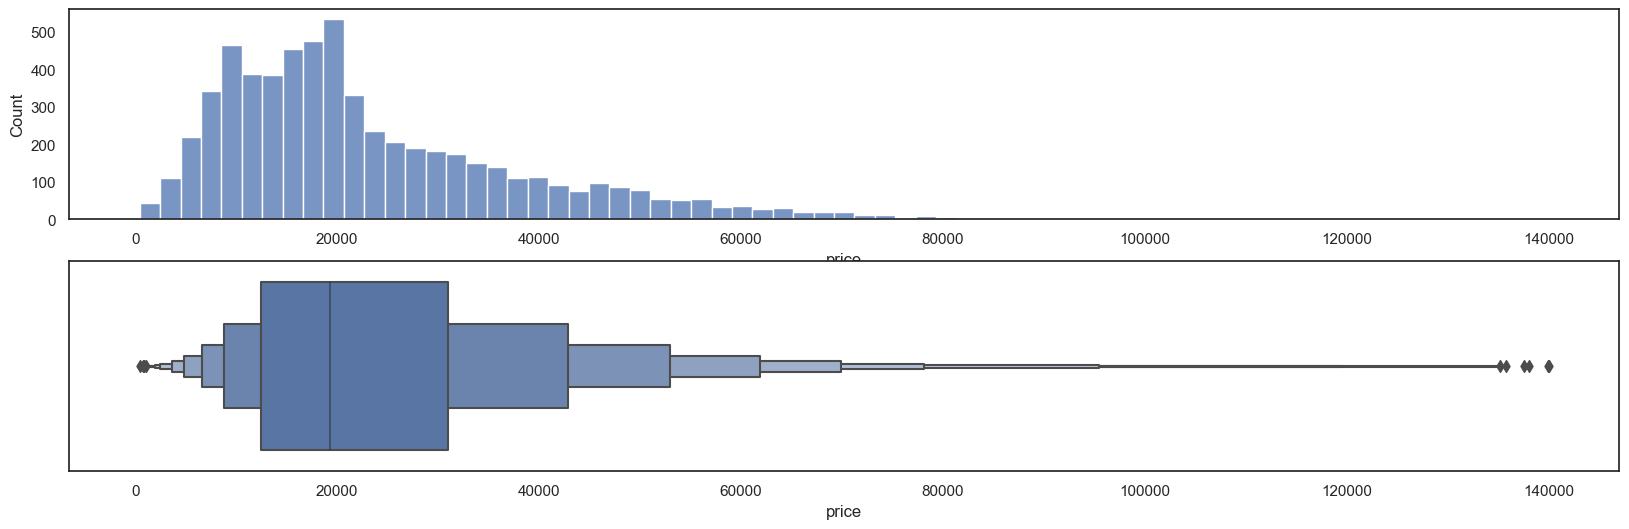

In [222]:
#1-1 price(目的変数)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.histplot(df.price, ax=ax1)
sns.boxenplot(x=df.price, ax=ax2)

# 一部高額なものもあるが違和感はない

<Axes: xlabel='brand', ylabel='price'>

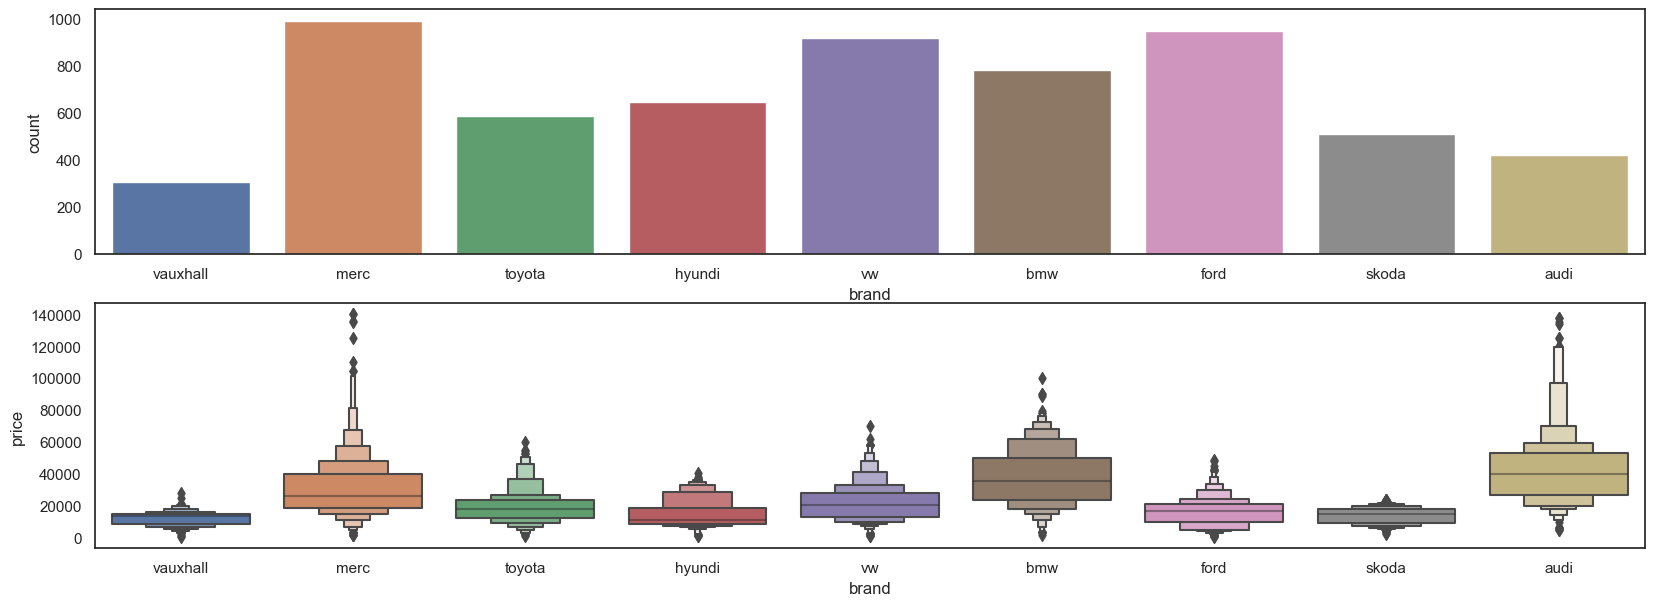

In [223]:
# 1-2 brand

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.countplot(df, x='brand', ax=ax1)
sns.boxenplot(df, x='brand', y='price', ax=ax2)

# 特にmerc（メルセデス）は大きく外れたものがあるうえ数も多い
# BMWとaudiが高い

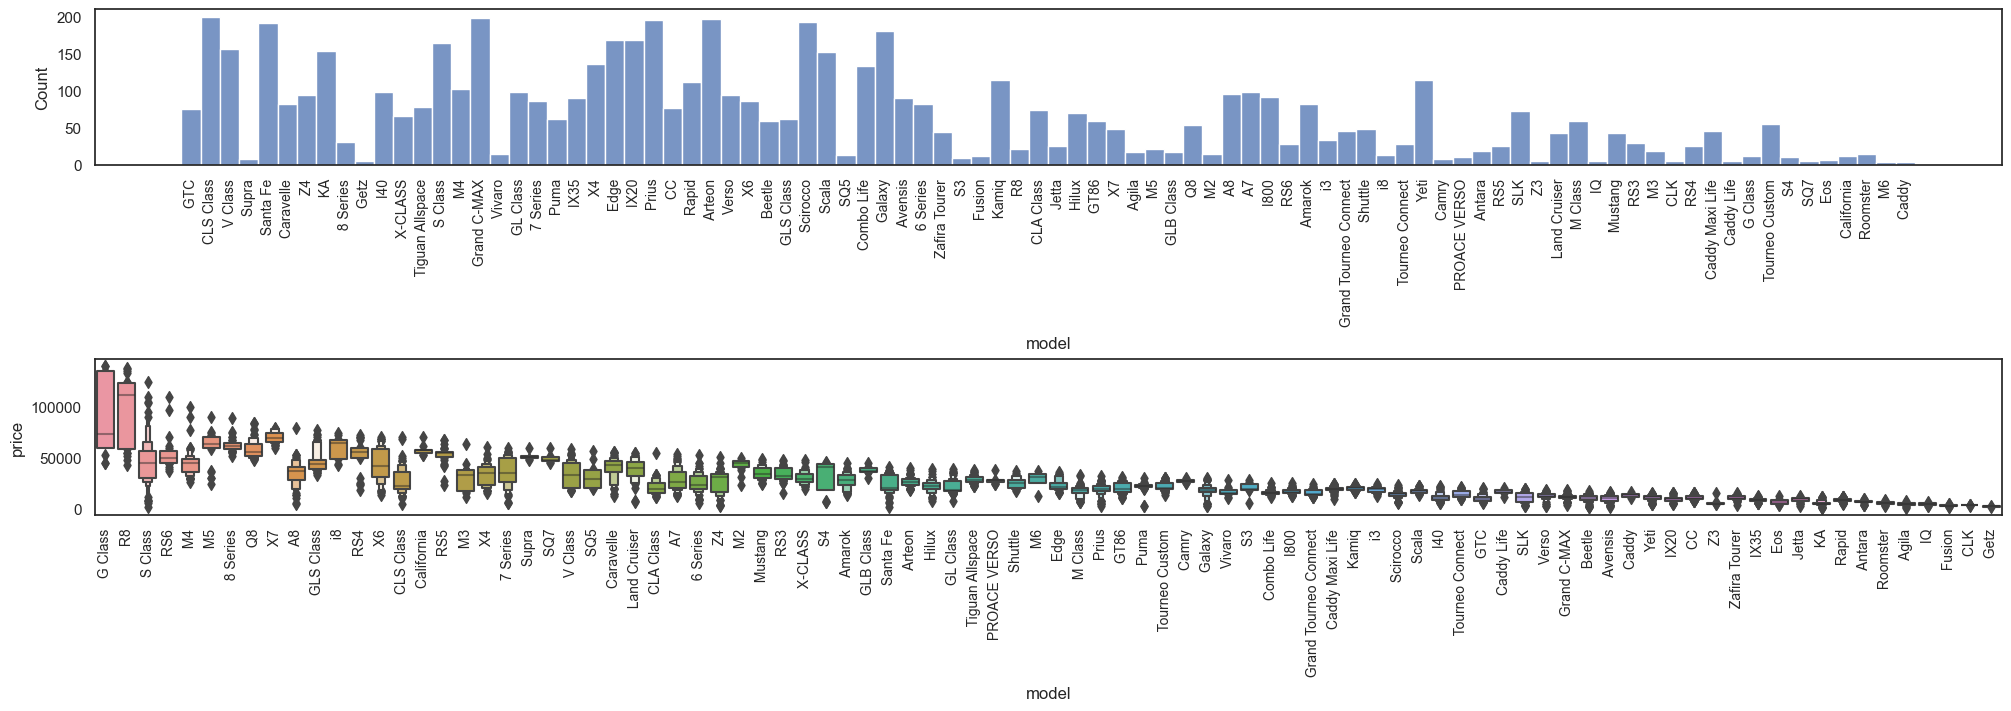

In [224]:
#1-3 model

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), layout='constrained')
sns.histplot(df.model, ax=ax1)
sns.boxenplot(df.sort_values('price', ascending=False), x='model', y='price', ax=ax2)
ax1.tick_params(axis='x', rotation=90, labelsize=10)
ax2.tick_params(axis='x', rotation=90, labelsize=10)

# 90車種もあるが、中古車価格といえば車種がベースになる。車種内のバラつきを他の特徴量で予測した方が確実。

<Axes: xlabel='year', ylabel='price'>

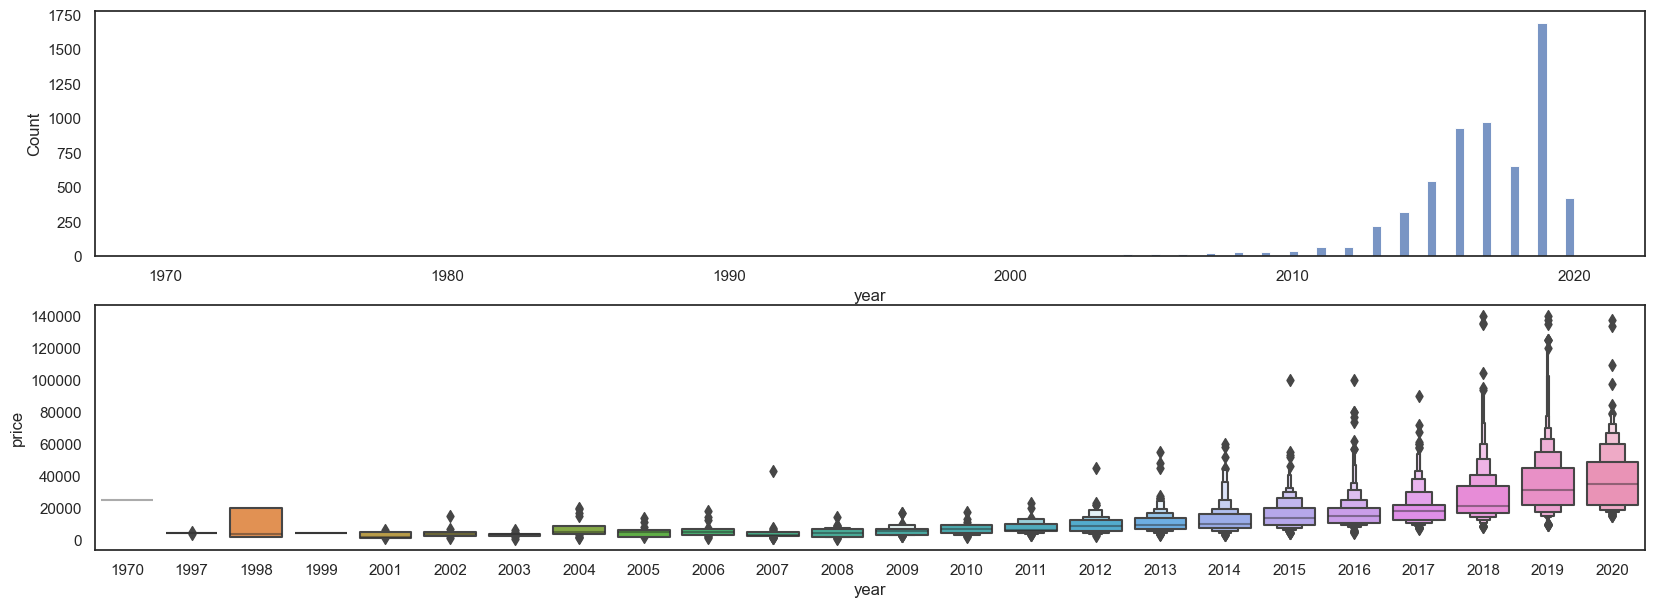

In [225]:
#1-4 year

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(df.year, ax=ax1)
sns.boxenplot(df, x='year', y='price', ax=ax2)

# 年式が新しいものが高く古いものは安い
# 「10年落ち」したものは少数の例外を除いて一様に低価格

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
2000,18935,skoda,Scala,2019,Other,3500,Petrol,145.0,47.1,1.0,15999
5166,18798,merc,SLK,2015,Other,39000,Diesel,150.0,56.5,2.1,12995


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize


<Axes: xlabel='transmission', ylabel='price'>

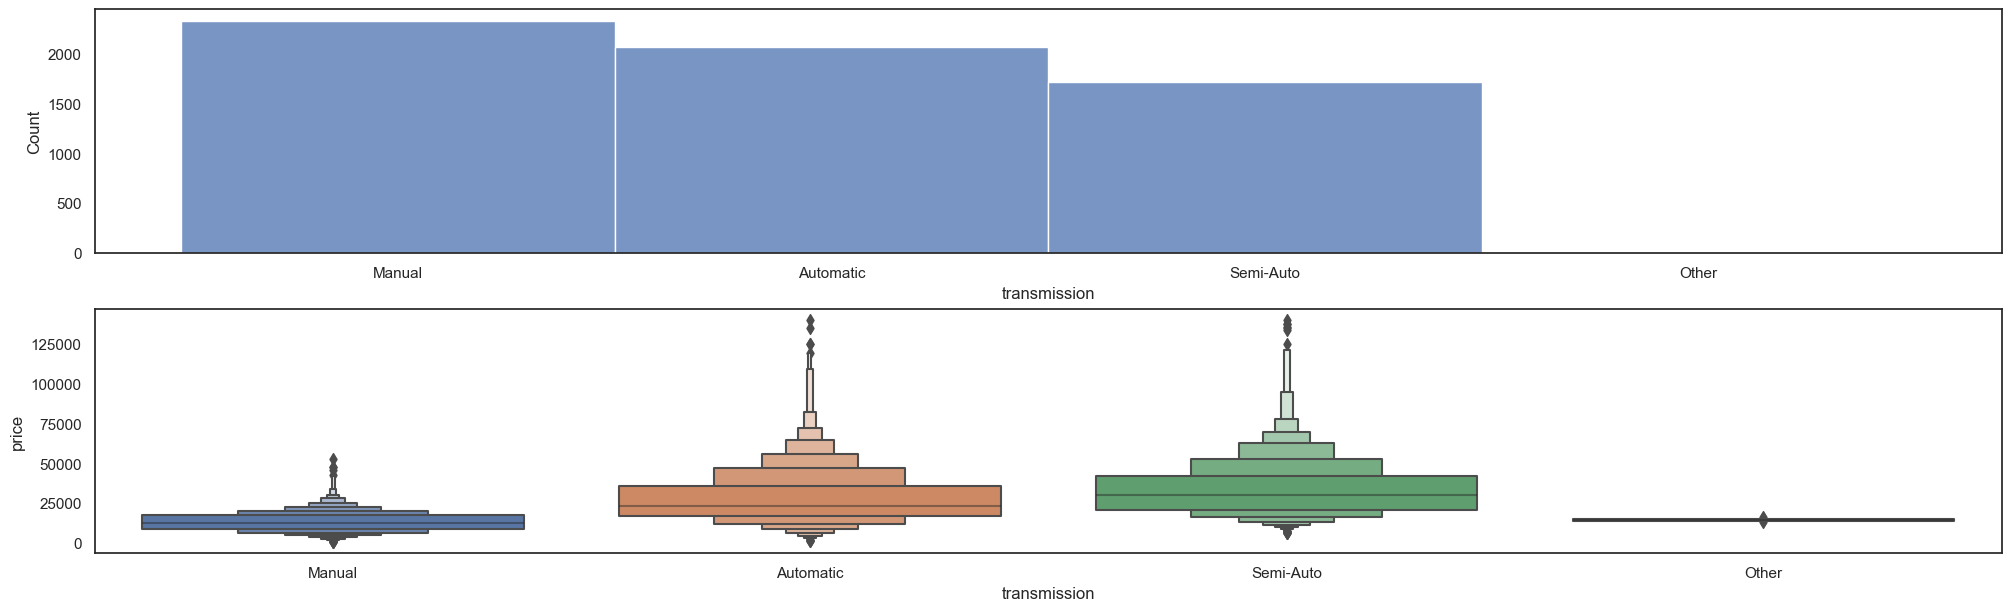

In [226]:
#1-5 transmission

display(df[df['transmission']=='Other'])
display(df_test[df_test['transmission']=='Other'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.histplot(df.transmission, ax=ax1)
sns.boxenplot(df, x='transmission', y='price', ax=ax2)

# Otherってなんだろ
# 解説動画でも言っていたがSemi-Autoも良くわからないが、一部切り替えが出来る車種があるのは知っているのでそのことか？
# いずれにせよ、これらは中古車価格の構成要素ではなく、古いものにManualが多いといった傾向が間接的に反映していると考えられる
# もちろん意味はあるがノイズになるなら利きを落とすか考慮対象外とする

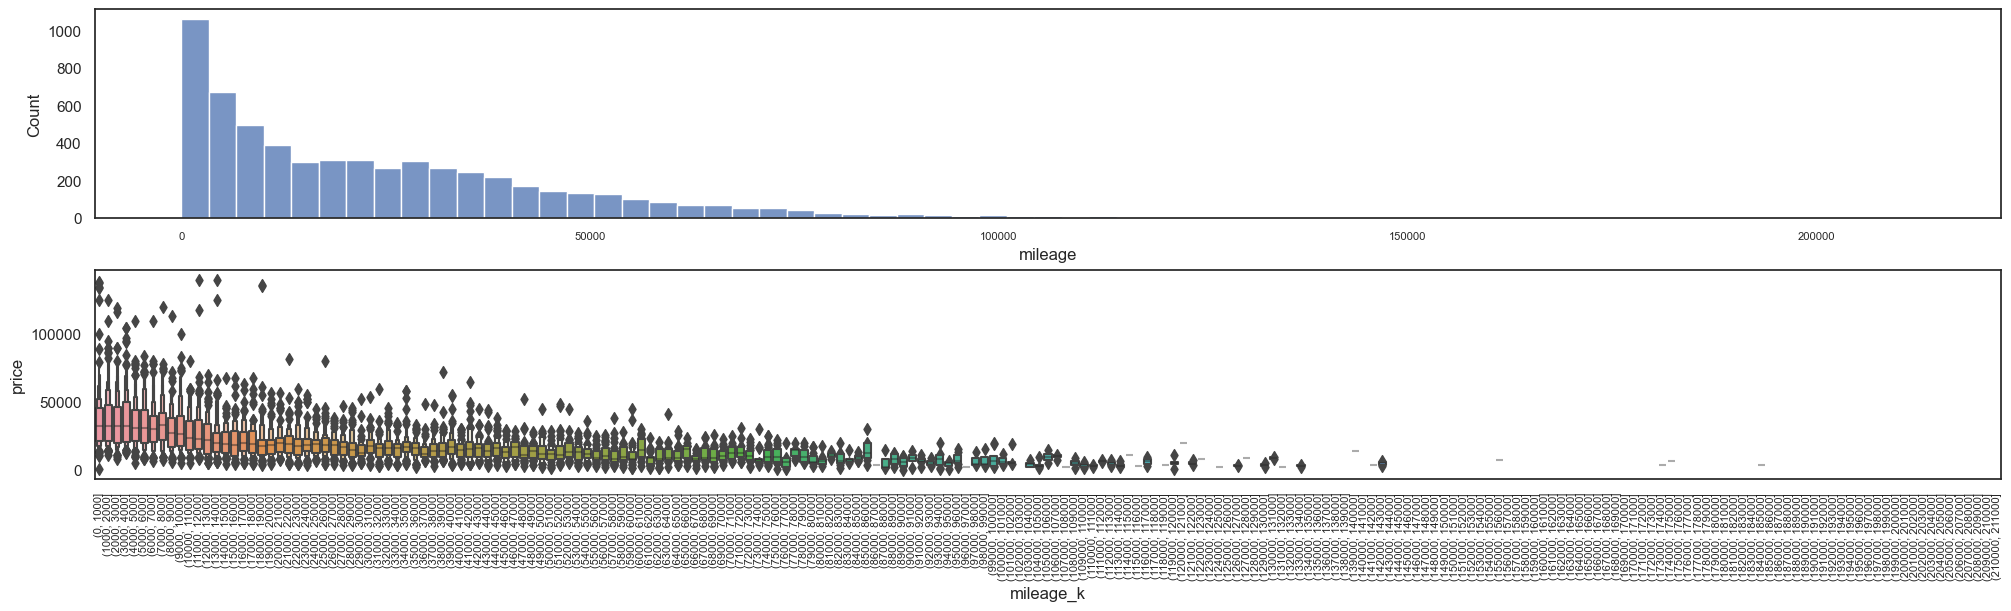

In [227]:
#1-6 mileage

df['mileage_k'] = pd.cut(df['mileage'], range(0, 212000, 1000))
df_test['mileage_k'] = pd.cut(df_test['mileage'], range(0, 212000, 1000))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.histplot(df.mileage, ax=ax1)
sns.boxenplot(data=df, x='mileage_k', y='price', ax=ax2)

ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='x', rotation=90, labelsize=8)

# 走行距離の長いものは安いという中古車の主要な減価要因
# あとで纏めてターゲットエンコーディングするので千キロ単位で纏めておく


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,mileage_k
1419,15421,bmw,i3,2015,Automatic,29465,Electric,0.0,470.8,1.0,17400,"(29000, 30000]"
4412,17538,bmw,i3,2017,Automatic,20321,Electric,135.0,470.8,0.0,18999,"(20000, 21000]"


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,mileage_k


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,mileage_k
121,18067,bmw,i3,2017,Automatic,19178,Other,0.0,470.8,0.6,"(19000, 20000]"
155,19225,bmw,i3,2016,Automatic,35446,Hybrid,0.0,470.8,0.0,"(35000, 36000]"
313,18076,bmw,i3,2015,Automatic,33931,Hybrid,0.0,470.8,0.0,"(33000, 34000]"
622,14766,bmw,i3,2016,Automatic,25269,Other,0.0,470.8,0.6,"(25000, 26000]"
828,13797,bmw,i3,2017,Automatic,41146,Hybrid,0.0,470.8,0.0,"(41000, 42000]"
893,19545,bmw,i3,2016,Automatic,9990,Electric,0.0,470.8,0.0,"(9000, 10000]"
961,13304,bmw,i3,2017,Automatic,20929,Hybrid,135.0,470.8,0.0,"(20000, 21000]"
1022,15617,bmw,i3,2017,Automatic,41949,Hybrid,140.0,470.8,0.0,"(41000, 42000]"
1343,15134,bmw,i3,2017,Automatic,22063,Hybrid,0.0,470.8,0.0,"(22000, 23000]"


<Axes: xlabel='fuelType', ylabel='price'>

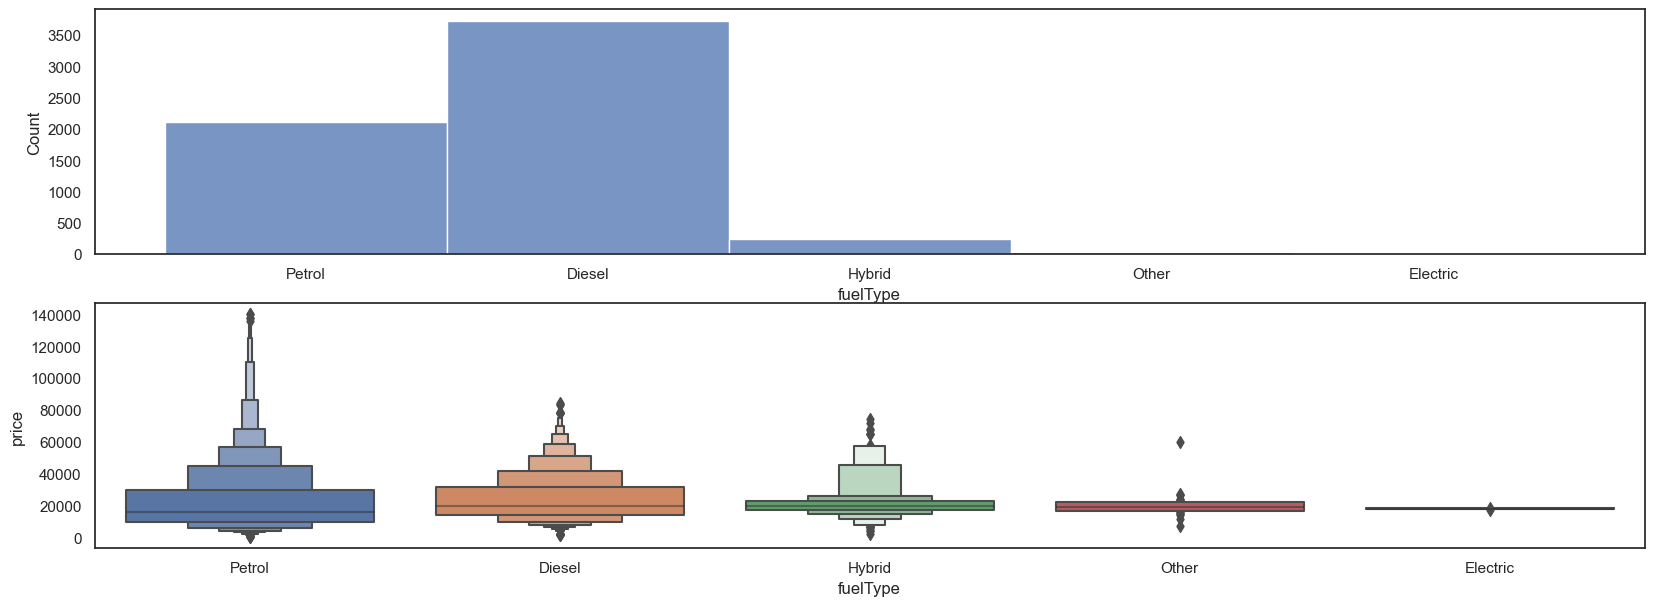

In [228]:
#1-7 fuelType

display(df[df['fuelType']=='Electric'])
display(df_test[df_test['model']=='i3'])
display(df_test[df_test['model']==' i3'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
sns.histplot(df.fuelType, ax=ax1)
sns.boxenplot( data=df, x='fuelType', y='price', ax=ax2)

# BMW i3はその名の通り電気自動車なのにほとんどElectricになっていない
# ここにもOtherがあるが不明
# 最初モデル名'i3'で検索してtestデータにないなら消してしまおうと思ったが、' i3'とアタマにスペースが入っていてびっくり
# ちなみにこれもモデルのグレードを構成する要素なので、使うかどうかは試しての判断


<Axes: xlabel='tax', ylabel='price'>

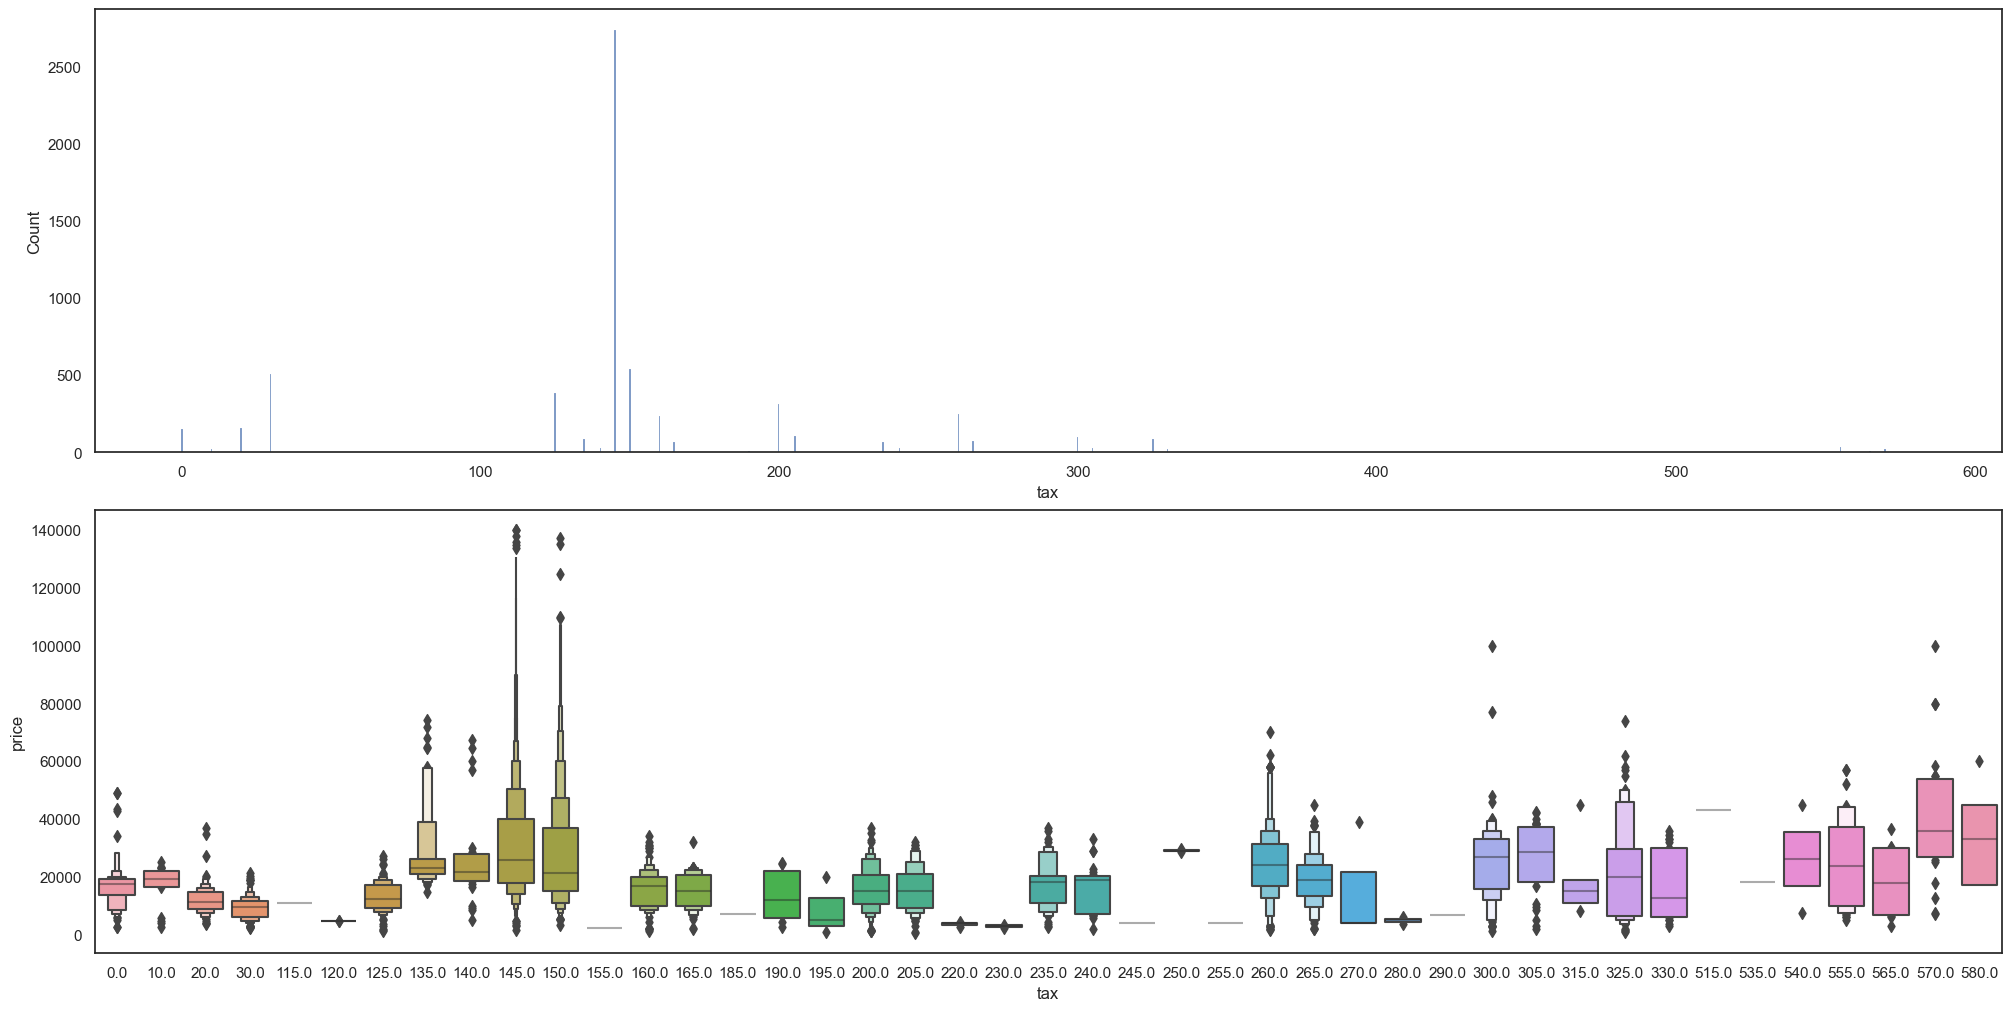

In [229]:
# 1-8 tax

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), layout='constrained')
sns.histplot(data=df, x='tax', ax=ax1)
sns.boxenplot(data=df, x='tax', y='price', ax=ax2)

# taxとは何の税金だろうか、いくつかの層をなしているように見える
# priceとの相関云々ではなく、priceの控除要因ではないかと思うが影響も小さく削除方針

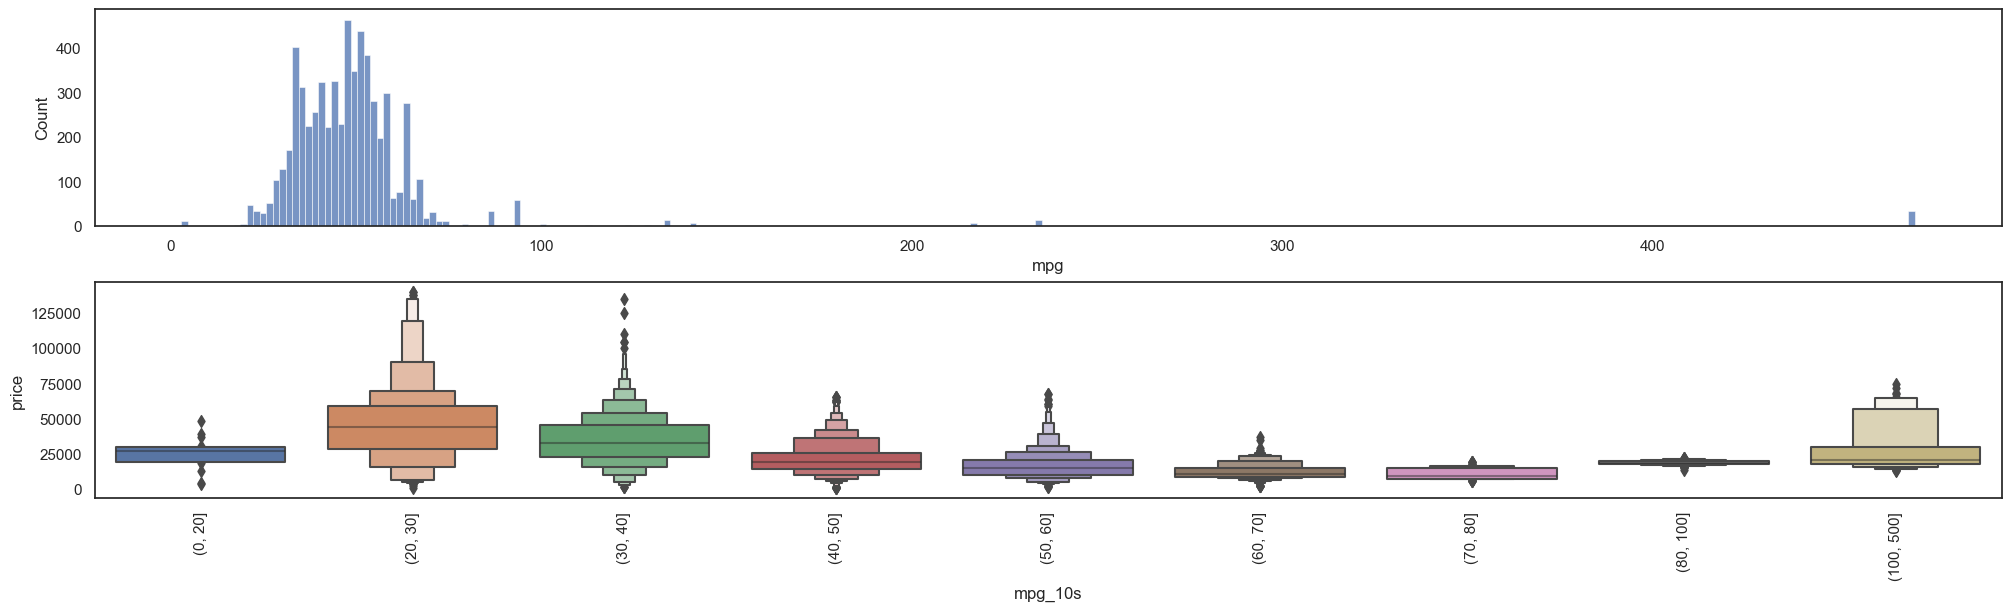

In [230]:
# 1-9 mpg

df['mpg_10s'] = pd.cut(df['mpg'], [0, 20, 30, 40, 50, 60, 70, 80, 100, 500])
df_test['mpg_10s'] = pd.cut(df_test['mpg'], [0, 20, 30, 40, 50, 60, 70, 80, 100, 500])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.histplot(df.mpg, ax=ax1)
sns.boxenplot(data=df, x='mpg_10s',y='price', ax=ax2)
ax2.tick_params(axis='x', rotation=90)

# 燃費470など有り得ないが、電気自動車だと分かり更に困惑
# 燃費は車種の属性であり中古車価格に直接関係しない

<Axes: xlabel='engineSize', ylabel='price'>

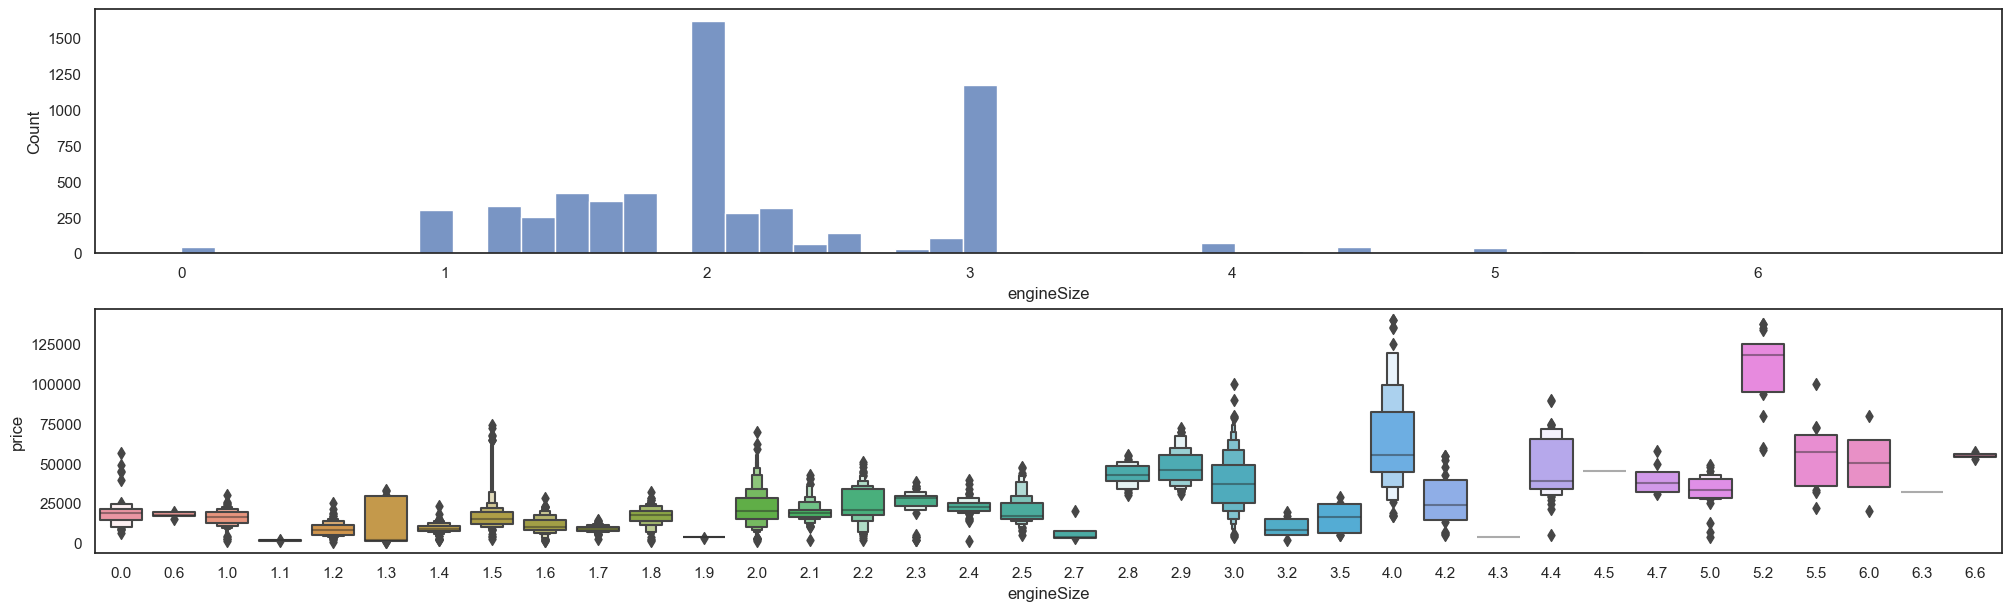

In [231]:
# engineSize

df['engineSize_15'] = pd.cut(df['engineSize'], 15)
df_test['engineSize_15'] = pd.cut(df_test['engineSize'], 15)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.histplot(df.engineSize, ax=ax1)
sns.boxenplot(data=df, x='engineSize',y='price', ax=ax2)

# 排気量は一般に大きいものが高い（特に同一車種なら間違いない）
# これも車種のグレードの構成要因だが比較的傾向が出ているので使用する方向感

## 前処理、特徴量エンジニアリング

### (1) 外れ値処理

In [232]:
# 2-1 mpg

display(df[df['mpg']>300])
display(df_test[df_test['model']==' i3'])

# BMWの特定モデル(i3)だけ年式に関わらず全てmpg470.8と突出しており極めて不自然（そんな燃費は存在しない）
# つまり、これは電気自動車なのだがfuelTypeはほとんどがHybridやOtherでElectricのものは2つしかない
# 実際、Hybrid車もあったようだがengineSize0だったり、逆にElectricが1.0だったりと不可解
# ノイズになるので除去したいがtestデータにも含まれているので削除できない。
# 但し、同一車種内で予測すれば無視できる、つまり、これを見てmodel毎の予測という発想に至った


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,mileage_k,mpg_10s,engineSize_15
185,14155,bmw,i3,2017,Automatic,17338,Hybrid,135.0,470.8,0.0,19495,"(17000, 18000]","(100, 500]","(-0.0066, 0.44]"
327,12107,bmw,i3,2016,Automatic,8421,Hybrid,0.0,470.8,0.0,19490,"(8000, 9000]","(100, 500]","(-0.0066, 0.44]"
535,17151,bmw,i3,2017,Automatic,16867,Hybrid,135.0,470.8,0.0,21494,"(16000, 17000]","(100, 500]","(-0.0066, 0.44]"
584,17962,bmw,i3,2017,Automatic,50867,Other,135.0,470.8,0.6,17600,"(50000, 51000]","(100, 500]","(0.44, 0.88]"
697,17362,bmw,i3,2016,Automatic,68000,Hybrid,0.0,470.8,0.0,15990,"(67000, 68000]","(100, 500]","(-0.0066, 0.44]"
939,16968,bmw,i3,2017,Automatic,10900,Hybrid,140.0,470.8,0.0,21500,"(10000, 11000]","(100, 500]","(-0.0066, 0.44]"
1419,15421,bmw,i3,2015,Automatic,29465,Electric,0.0,470.8,1.0,17400,"(29000, 30000]","(100, 500]","(0.88, 1.32]"
1607,13674,bmw,i3,2017,Automatic,36429,Hybrid,0.0,470.8,0.0,18500,"(36000, 37000]","(100, 500]","(-0.0066, 0.44]"
1635,14796,bmw,i3,2017,Automatic,20082,Hybrid,135.0,470.8,0.0,20495,"(20000, 21000]","(100, 500]","(-0.0066, 0.44]"
1860,14861,bmw,i3,2017,Automatic,23983,Hybrid,0.0,470.8,0.0,19000,"(23000, 24000]","(100, 500]","(-0.0066, 0.44]"


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,mileage_k,mpg_10s,engineSize_15
121,18067,bmw,i3,2017,Automatic,19178,Other,0.0,470.8,0.6,"(19000, 20000]","(100, 500]","(0.413, 0.827]"
155,19225,bmw,i3,2016,Automatic,35446,Hybrid,0.0,470.8,0.0,"(35000, 36000]","(100, 500]","(-0.0062, 0.413]"
313,18076,bmw,i3,2015,Automatic,33931,Hybrid,0.0,470.8,0.0,"(33000, 34000]","(100, 500]","(-0.0062, 0.413]"
622,14766,bmw,i3,2016,Automatic,25269,Other,0.0,470.8,0.6,"(25000, 26000]","(100, 500]","(0.413, 0.827]"
828,13797,bmw,i3,2017,Automatic,41146,Hybrid,0.0,470.8,0.0,"(41000, 42000]","(100, 500]","(-0.0062, 0.413]"
893,19545,bmw,i3,2016,Automatic,9990,Electric,0.0,470.8,0.0,"(9000, 10000]","(100, 500]","(-0.0062, 0.413]"
961,13304,bmw,i3,2017,Automatic,20929,Hybrid,135.0,470.8,0.0,"(20000, 21000]","(100, 500]","(-0.0062, 0.413]"
1022,15617,bmw,i3,2017,Automatic,41949,Hybrid,140.0,470.8,0.0,"(41000, 42000]","(100, 500]","(-0.0062, 0.413]"
1343,15134,bmw,i3,2017,Automatic,22063,Hybrid,0.0,470.8,0.0,"(22000, 23000]","(100, 500]","(-0.0062, 0.413]"


In [233]:
# 2-2 year

display(df[df['year']<=2010])

mask =df['year']<=2010
df.loc[mask, 'year'] = 2010
mask =df_test['year']<=2010
df_test.loc[mask, 'year'] = 2010

df.groupby('year')[['price']].mean().T

# 10年落ちを纏めた
# 纏めないケースとの比較でも不悪なのでこれを使う

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,mileage_k,mpg_10s,engineSize_15
12,18180,hyundi,Getz,2007,Manual,90800,Petrol,125.0,51.4,1.1,1295,"(90000, 91000]","(50, 60]","(0.88, 1.32]"
67,17202,bmw,6 Series,2008,Automatic,94000,Diesel,305.0,39.2,3.0,8499,"(93000, 94000]","(30, 40]","(2.64, 3.08]"
69,15550,ford,KA,2008,Manual,76000,Petrol,205.0,43.5,1.3,795,"(75000, 76000]","(40, 50]","(0.88, 1.32]"
76,17020,ford,Fusion,2010,Automatic,26588,Petrol,260.0,37.7,1.6,4750,"(26000, 27000]","(30, 40]","(1.32, 1.76]"
100,13557,vw,Caravelle,2005,Automatic,140000,Diesel,325.0,31.0,2.5,13990,"(139000, 140000]","(30, 40]","(2.2, 2.64]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,18314,ford,Fusion,2005,Manual,64000,Diesel,30.0,64.2,1.4,2395,"(63000, 64000]","(60, 70]","(1.32, 1.76]"
5927,19106,vw,Scirocco,2008,Manual,82156,Petrol,260.0,37.2,2.0,5000,"(82000, 83000]","(30, 40]","(1.76, 2.2]"
5994,13454,ford,KA,2010,Manual,48000,Petrol,30.0,55.4,1.2,2995,"(47000, 48000]","(50, 60]","(0.88, 1.32]"
6045,16964,toyota,Avensis,2010,Automatic,80000,Diesel,260.0,42.2,2.2,5495,"(79000, 80000]","(40, 50]","(1.76, 2.2]"


year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
price,5764.7,7597.415,9814.738,10892.486,12569.586,15431.346,16928.709,19617.29,26525.609,34972.947,37719.896


### （2）特徴量生成

In [234]:
# 今回は、引き算の特徴量エンジニアリングばかりで新しい要素はなし

### （3）質的変数のエンコーディング

In [235]:
display(df.describe(include='object'))
print(set(df['brand']))
print(set(df['model']))
print(set(df['transmission']))
print(set(df['fuelType']))

# modelの前に全て半角スペースが入っている点には注意が必要

,brand,model,transmission,fuelType
count,6105,6105,6105,6105
unique,9,90,4,5
top,merc,CLS Class,Manual,Diesel
freq,990,200,2325,3724


{'merc', 'vw', 'bmw', 'audi', 'vauxhall', 'skoda', 'toyota', 'hyundi', 'ford'}
{' M Class', ' Edge', ' IX35', ' Z3', ' RS3', ' I40', ' M2', ' Rapid', ' M5', ' Vivaro', ' Caddy', ' Kamiq', ' Fusion', ' i8', ' M4', ' SLK', ' Grand C-MAX', ' Tourneo Connect', ' I800', ' Land Cruiser', ' Antara', ' Supra', ' 8 Series', ' S3', ' 7 Series', ' Prius', ' Scirocco', ' Zafira Tourer', ' Eos', ' GLB Class', ' IQ', ' Z4', ' SQ5', ' Hilux', ' Caravelle', ' RS5', ' Scala', ' R8', ' Verso', ' S Class', ' Grand Tourneo Connect', ' M6', ' Avensis', ' Caddy Life', ' RS4', ' V Class', ' CLK', ' PROACE VERSO', ' SQ7', ' Caddy Maxi Life', ' KA', ' Getz', ' IX20', ' CC', ' GTC', ' X-CLASS', ' Amarok', ' Santa Fe', ' Q8', ' G Class', ' Agila', ' Tiguan Allspace', ' X4', ' CLS Class', ' X7', ' CLA Class', ' Puma', ' i3', ' Combo Life', ' Jetta', ' Tourneo Custom', ' GLS Class', ' A7', ' Arteon', ' California', ' S4', ' X6', ' RS6', ' GT86', ' Camry', ' Galaxy', ' Yeti', ' A8', ' Mustang', ' 6 Series', ' Rooms

In [236]:
# 4-0 バリデーションデータの分割

df_train, df_val = train_test_split(df, test_size=0.2, random_state=0)

In [237]:
# 4-1 ターゲットエンコーディング

# year
dic_YR = df_train.groupby('year')['price'].median().to_dict()
df_train['year'] = df_train['year'].map(dic_YR)
df_val['year'] = df_val['year'].map(dic_YR)

# engineSize
dic_ES = df_train.groupby('engineSize')['price'].median().to_dict()
df_train['engineSize'] = df_train['engineSize'].map(dic_ES).fillna(df_train['price'].median())
df_val['engineSize'] = df_val['engineSize'].map(dic_ES).fillna(df_train['price'].median())

# mileage_k
df_train.groupby('mileage_k')['price'].median()
dic_MI = df_train.groupby('mileage_k')['price'].median().to_dict()
df_train['mileage_k'] = df_train['mileage_k'].map(dic_MI).fillna(df_train['price'].median()).astype(float)
df_val['mileage_k'] = df_val['mileage_k'].map(dic_MI).fillna(df_train['price'].median()).astype(float)


# ターゲットエンコーディングを行うメリットはいろいろある。まず厳密にスケールが揃う。特徴量が増えない。自然に順相関になる。
# 以下の注意点があるほか実装方法が複雑との見解もあるが、変換辞書を作成してmapで適用してやれば案外シンプル。
# バリデーションデータに要素がない場合などの欠損発生にも柔軟に対応できる。
# なお、必ず訓練データとバリデーションデータを先に分割し、訓練データの目的変数だけを使ってエンコードを行う必要がある
# バリデーションデータの目的変数がリークされると、バリデーションスコアだけが異常に好転してしまうことに注意


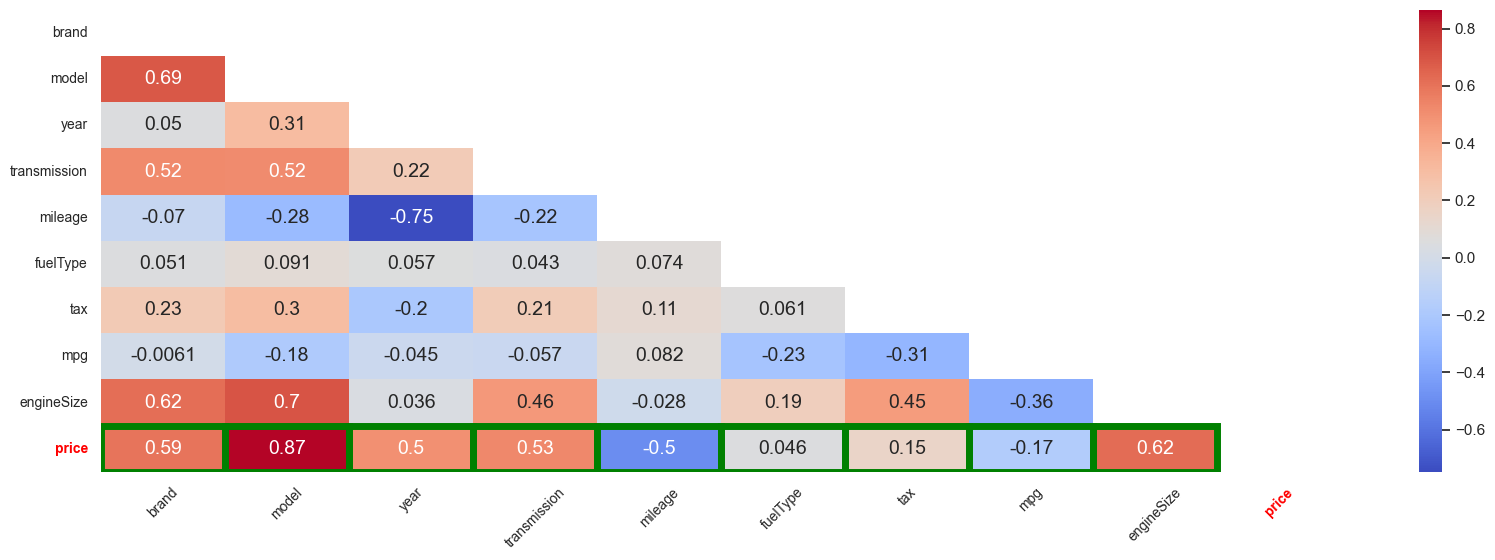

In [246]:
# ヒートマップ,相関係数
corr = df_train.drop(columns=['carID']).corr()
fig, ax = plt.subplots(figsize=(20, 6))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', annot_kws={'size':14})
ax.tick_params(axis='x', labelsize=10, rotation=45)
ax.tick_params(axis='y', labelsize=10)

# 目的変数の枠線の追加
index = list(corr.columns).index('price')
for i in range(len(corr.columns)):
    if i > index:
        plt.gca().add_patch(plt.Rectangle((index, i), 1, 1,
                                          fill=False, edgecolor='green', lw=5))
    elif i < index:
        plt.gca().add_patch(plt.Rectangle((i, index), 1, 1,
                                          fill=False, edgecolor='green', lw=5))

# 目的変数の強調
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == 'price':
        label.set_color('red')
        label.set_fontweight('bold')
for i, label in enumerate(ax.get_yticklabels()):
    if label.get_text() == 'price':
        label.set_color('red')
        label.set_fontweight('bold')
plt.show()

# yearとmileageの（逆）相関が大きいのは当然だが、多重共線性の目安は0.8以上
# 実際、両方入れた方がスコアは大きく改善するので問題視しない

## モデル作成、予測と評価

In [239]:
X_train = df_train
y_train = df_train.price
X_test = df_val
y_test = df_val.price

In [240]:
# モデルの適用と予測の実施

LR_model = LinearRegression()
tree_model = DecisionTreeRegressor()

# 各データをmodel毎にマスキング
for model in df['model'].unique():
    mask = X_train['model'] == model
    masked_X_train = X_train.loc[mask,['year', 'mileage_k', 'engineSize']]
    masked_y_train = X_train.loc[mask, 'price']
    mask = X_test['model'] == model
    masked_X_test = X_test.loc[mask, ['year', 'mileage_k', 'engineSize']]
    masked_y_test = X_test.loc[mask, 'price']

# データ零のケースをスキップしてマスキングしたデータでモデルを訓練（1データ以上が必要）
    if len(masked_X_train) == 0:
        continue
    else:
        LR_model = LR_model.fit(masked_X_train, masked_y_train)
        tree_model = tree_model.fit(masked_X_train, masked_y_train)
# データ零のケースをスキップして予測を実施（1データ以上が必要）
    if len(masked_X_test) == 0:
        continue
    else:
        X_test.loc[mask, 'LR_pred'] = LR_model.predict(masked_X_test)
        X_test.loc[mask, 'tree_pred'] = tree_model.predict(masked_X_test)

# 重回帰の予測に上下限を設定（訓練データの最大最小値）
hair1 = X_test['LR_pred'] < 450
hair2 = X_test['LR_pred'] > 140000
X_test.loc[hair1, 'LR_pred'] = 450
X_test.loc[hair2, 'LR_pred'] = 140000

# RMSE計算
print(f'Linear_pred: {np.sqrt(mean_squared_error(X_test["LR_pred"], y_test)):.2f}')
print(f'tree_pred  : {np.sqrt(mean_squared_error(X_test["tree_pred"], y_test)):.2f}')

# 特徴量は、グレード要因としての排気量のほか、減価要因として年式と走行距離のみ採用
# あとはモデルに包含されているか、ノイズにしかならないので使用しない
# 90通りの予測もマスキングを使用した配列計算で行えばすっきり実施できる
# 通常、訓練データからは目的変数を除外するが、マスキングの関係上、一旦は含めて対応している
# 予測データもテストデータのデータフレーム上の列に格納することでバラバラの予測データを一つに集約できる


Linear_pred: 3564.94
tree_pred  : 4007.86


In [241]:
X_test.describe()

,carID,year,mileage,tax,mpg,engineSize,price,mileage_k,LR_pred,tree_pred
count,1221.000,1221.000,1221.000,1221.000,1221.000,1221.000,1221.000,1221.000,1221.000,1221.000
mean,15837.905,21272.649,24537.110,153.845,50.736,22451.939,23106.305,21519.585,23316.729,23353.755
std,2224.005,9033.028,23536.807,80.575,39.163,12134.570,15306.625,8459.965,15149.824,15501.500
min,12015.000,4650.000,5.000,0.000,2.800,1845.000,1295.000,2395.000,591.767,1795.000
25%,13937.000,14995.000,5788.000,145.000,39.200,16491.000,12500.000,15500.000,12534.781,12950.000
50%,15766.000,17995.000,18398.000,145.000,47.100,19998.000,19295.000,19000.000,19372.318,19498.000
75%,17833.000,31995.000,36189.000,160.000,54.300,27997.500,29495.000,31720.500,29245.355,29490.000
max,19629.000,35400.000,185000.000,580.000,470.800,116995.000,139948.000,33992.000,140000.000,139995.000


(-20000.000, 20000.000)

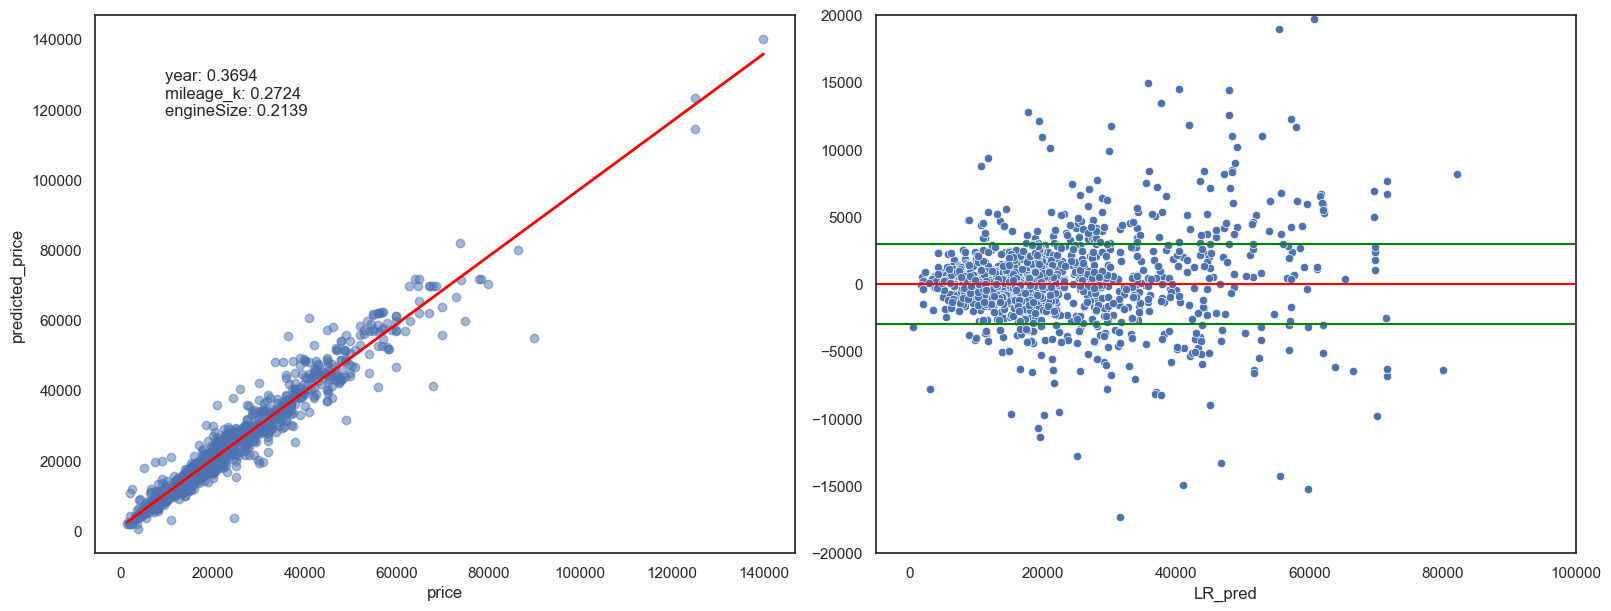

In [242]:
# 可視化

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), layout='constrained')
p = X_test['LR_pred']
sns.regplot(x=y_test, y=p, scatter_kws={'alpha':0.5}, ci=False,
            line_kws={'color':'red', 'lw':2}, ax=ax1, label='linear_model')
coeff_str = '\n'.join([f'{col}: {coef:.4f}' for col, coef in zip(LR_model.feature_names_in_, LR_model.coef_)])
ax1.annotate(coeff_str, xy=(0.1, 0.90), xycoords='axes fraction', verticalalignment='top')
sns.scatterplot(x=p, y=(p-y_test), ax=ax2)
ax1.set_ylabel('predicted_price')
ax2.hlines(-3000, -5000, 100000, color='green')
ax2.hlines(3000, -5000, 100000, color='green')
ax2.hlines(0, -5000, 100000, color='red')
ax2.set_xlim(-5000, 100000)
ax2.set_ylim(-20000, 20000)


## ちなみに、LightGBMでざっくりやってみると・・・

In [250]:
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\used_car\\train.csv')
df_train, df_val = train_test_split(df, test_size=0.2)

# brand
dic_BR = df_train.groupby('brand')['price'].mean().to_dict()
df_train['brand'] = df_train['brand'].map(dic_BR)
df_val['brand'] = df_val['brand'].map(dic_BR)

# model
dic_MO = df_train.groupby('model')['price'].mean().to_dict()
df_train['model'] = df_train['model'].map(dic_MO)
df_val['model'] = df_val['model'].map(dic_MO)

# transmission
dic_TR = df_train.groupby('transmission')['price'].mean().to_dict()
df_train['transmission'] = df_train['transmission'].map(dic_TR)
df_val['transmission'] = df_val['transmission'].map(dic_TR)

# fuelType
dic_FT = df_train.groupby('fuelType')['price'].mean().to_dict()
df_train['fuelType'] = df_train['fuelType'].map(dic_FT)
df_val['fuelType'] = df_val['fuelType'].map(dic_FT)

X_train = df_train.drop(columns=['carID', 'price', 'tax'])
y_train = df_train.price
X_test = df_val.drop(columns=['carID', 'price', 'tax'])
y_test = df_val.price

# 質的変数は変換が必要なので取り敢えず出来合いのターゲットエンコーディングで変換
# carIDのほか、意味不明なtaxだけは落とす

In [251]:
# Light GBM
import lightgbm as lgb

params = {'objective':'regression', 'metrics':'rmse', 'seed':42}
trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(params, trains, valid_sets=valids,
                      num_boost_round=500, early_stopping_rounds=100)
lgb_pred = lgb_model.predict(X_test)

# 概ねRMSE3000くらいはほとんど何も調整しなくても出る

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 4884, number of used features: 8
[LightGBM] [Info] Start training from score 23723.615889
[1]	valid_0's rmse: 15037.8
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 13705.4
[3]	valid_0's rmse: 12521.1
[4]	valid_0's rmse: 11477
[5]	valid_0's rmse: 10548.9
[6]	valid_0's rmse: 9728.05
[7]	valid_0's rmse: 8977.92
[8]	valid_0's rmse: 8334.11
[9]	valid_0's rmse: 7761.97
[10]	valid_0's rmse: 7243.99
[11]	valid_0's rmse: 6774.2
[12]	valid_0's rmse: 6376.07
[13]	valid_0's rmse: 6016.74
[14]	valid_0's rmse: 5706.11
[15]	valid_0's rmse: 5441.41
[16]	valid_0's rmse: 5207.89
[17]	valid_0's rmse: 5013.27
[18]	valid_0's rmse: 4840.29
[19]	valid_0's rmse: 4687.03
[20]	valid_0's rmse: 4548.31
[21]	valid_0's rmse: 442

Text(0.5, 1.0, 'lgb_pred')

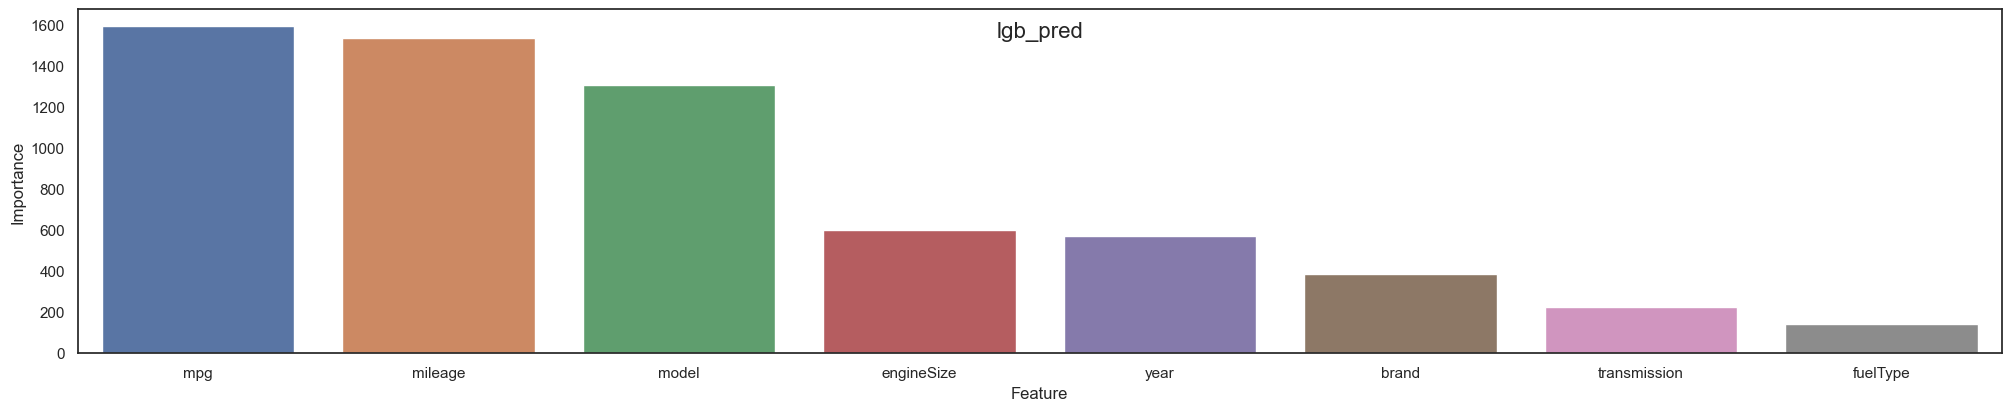

In [252]:
importance_lgb = lgb_model.feature_importance()
importance_df_lgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_lgb})
importance_df_lgb = importance_df_lgb.sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(20, 4), layout='constrained')
sns.barplot(data=importance_df_lgb, x='Feature', y='Importance', ax=ax)
ax.set_title('lgb_pred', pad=-20, fontsize=16)

# LightGBMはtax以外のデータ全体で予測している
# mpgを除けばmileage, enginSize, yearが上位にありイメージに合う
# ちなみに、mpg(mpg_10s)を加えてもlinear_modelのパフォーマンスはほとんど変わらない

In [255]:
model = LinearRegression()
model = model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f'linear_pred RMSE : {np.sqrt(mean_squared_error(pred, y_test)):.2f}')

# 同じ条件で重回帰で予測するとこのくらい

linear_pred RMSE : 6634.58
